# Integration methods comparison

In [2]:
import stagem1.temporal_integration as sti
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

## Error estimation
Advancement ($=x(a,t)-x(a,t=0)$) are computed for all particules with the different integrations methods: Euler, RK2, RK4 with a 30 min simulation time step, and RK4 with a 3h simulation time step. These advancements are then compared (simple difference) with the advancement computed by RK4 with a simulation time step of 10 min. We assume that this short time step linked with the RK4 method allow us to consider this as the reference: it will approachs the analytical answer that we can't compute. 

The error calculated by Euler in case: $U(t)=u_w cos(wt+\phi) + u_m$, i.e`k=0`, `advected=0` (unadvected) is :
$$\alpha = \frac{ u_w  t_{step}}{2}(cos(\phi)-cos(wt+\phi)) - \frac{w*u_w*t_{step}²}{6}(sin(wt+\phi)-sin(\phi)))$$ avec $t_{step}$ the simulation time step.

### Test with `k=0` (-> $\phi=0$), `uw=0.1`, `w=w2=2*np.pi/(12*3600)`

For Euler method the error at order 1 is : $\alpha=|90*(1-cos(w2*t))|$.  

It is 0 at t=0, and then it oscillates between 0 and 180 with a periode of 0.5 day (pulsation w2).
The following second plot confirms calculations.

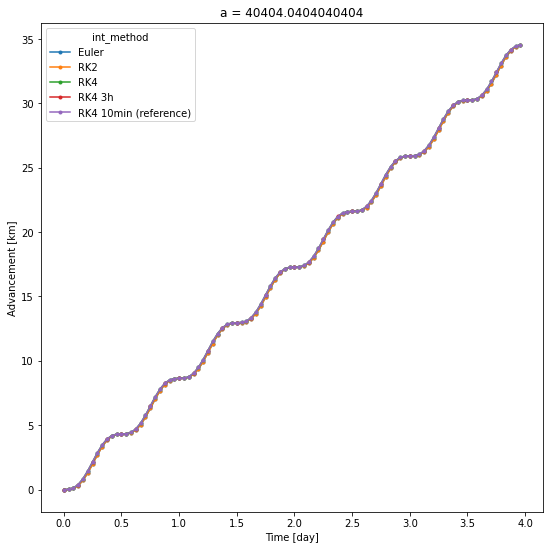

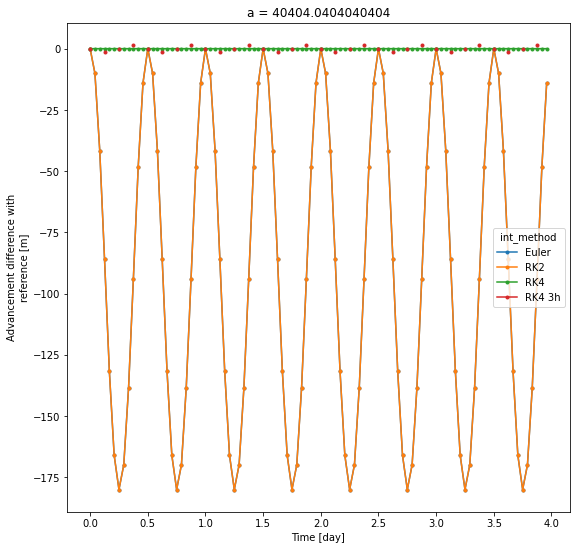

In [23]:
x=sti.SetUp(advected=0, k=0)# um=1, uw=0.5, advected=0)
comp=sti.Temp_Int_Comp(x, advected=0, k=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
comp.print_diff_adv()

### Test with `k=k2` (i.e longueur d'onde de 100km) unadvected
We take back the normal case with `k=k2` to see if the precedent error formula is still relevent.
The first serie of plot represents the advancement and the difference of this advancement with the reference advancement for each method.
The second represents the advancement average on particules, thus on initial phase and the absolute difference of advancement also average on particules.

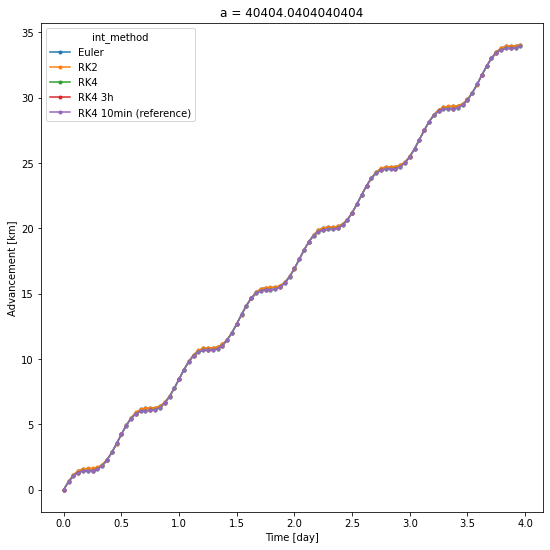

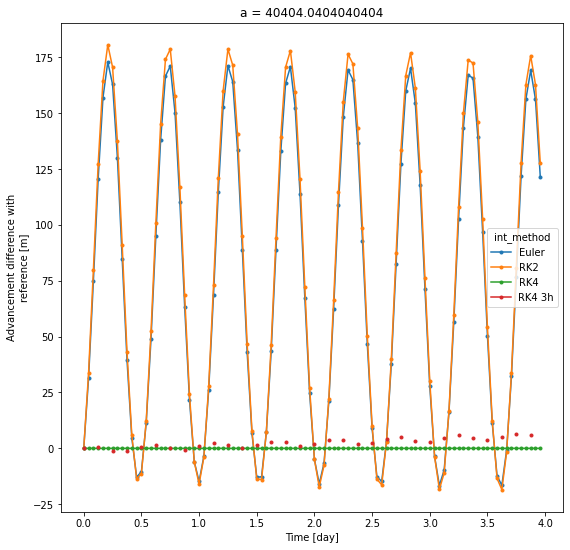

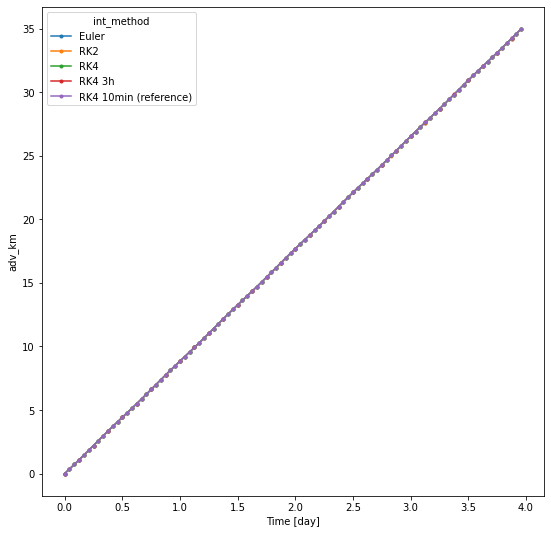

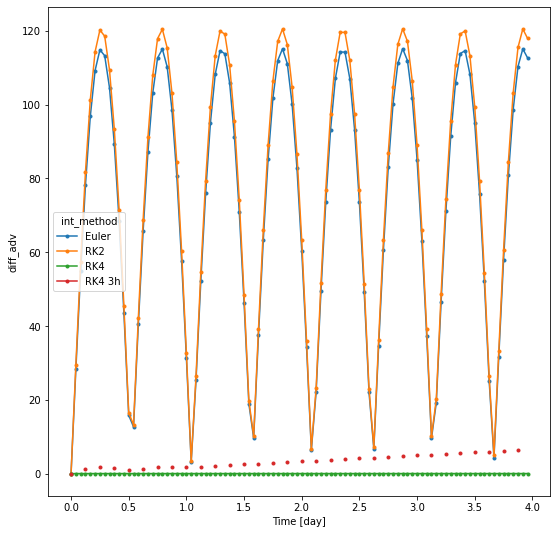

In [22]:
y=sti.SetUp(advected=0)# um=1, uw=0.5, advected=0)
compy=sti.Temp_Int_Comp(y,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compy.print_diff_adv()
compy.print_diff_adv_mean()

The second print shows that `k=k2` does not impact the amplitude which is still around 90. Difference with last section appear to correspond to a change of $\phi$ in error formula (average value = $cos(\phi)$ and oscillation shift).
$90*cos(\phi_0) = 90*cos(k2*40404)=-74$ 
Last print shows that the absolute value and the average on particules erase a part of the amplitude.

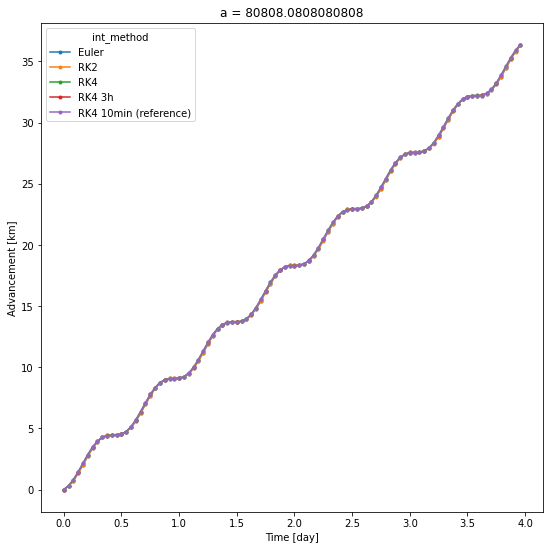

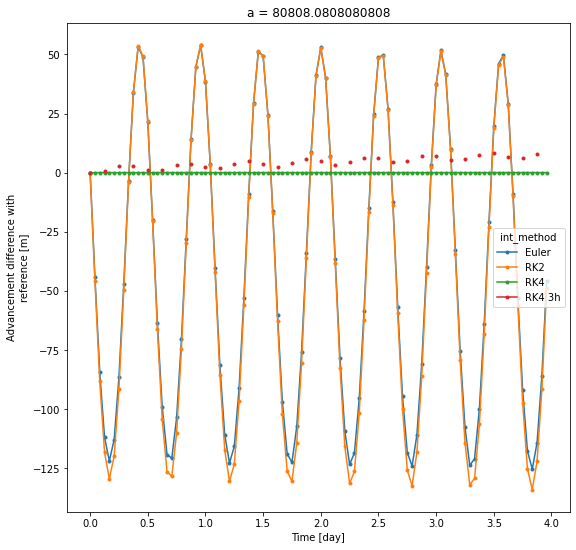

In [25]:
z=sti.SetUp(advected=0)# um=1, uw=0.5, advected=0)
compz=sti.Temp_Int_Comp(z,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compz.print_diff_adv(traj=40)

$90*cos(\phi_0) = 90*cos(k2*40404)=32$ 

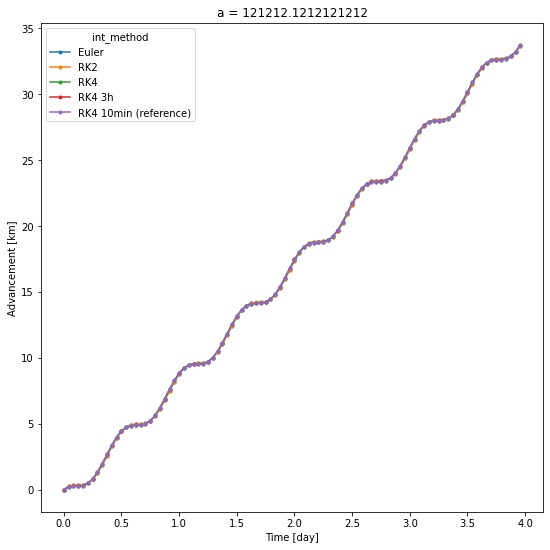

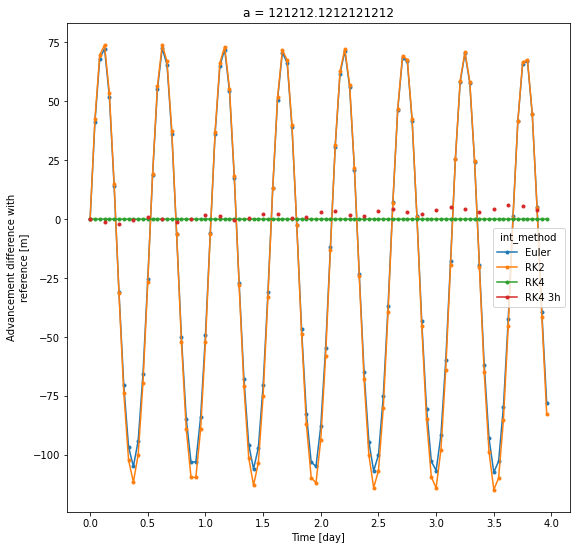

In [26]:
z=sti.SetUp(advected=0)# um=1, uw=0.5, advected=0)
compz=sti.Temp_Int_Comp(z,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compz.print_diff_adv(traj=60)

$90*cos(\phi_0) = 90*cos(k2*40404)=21$ 

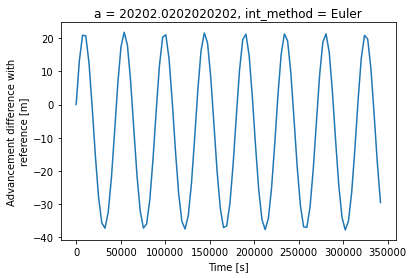

In [84]:
z=sti.SetUp(advected=0,time= list(np.arange(0,sti.d2s*4, sti.h2s/6)),
                 otime=list(np.arange(0, sti.d2s*4, sti.h2s)))# um=1, uw=0.5, advected=0)
compz=sti.Temp_Int_Comp(z,advected=0)#, um=1, uw=0.5, advected=0) #CAUTION: add parameters if parameters add in SetUp x different than default
compz.ds.diff_adv.sel(int_method='Euler').isel(a=10).plot(x='otime')
#compz.print_diff_adv(traj=5)
#compz.print_diff_adv_mean()

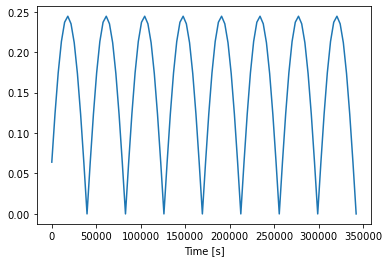

In [15]:
#comp.ds.velocities.cumsum('otime').sel(int_method='Euler').isel(a=20).plot()
v=0.1*np.cos(x['w']*x.out_ds.otime + sti.k2*x['p'].isel(otime=0)+np.pi/1)
abs(v.cumsum('otime')).mean('a').plot()

### Linear regression on advancement ???

In [14]:
comp.reglin_mean_adv()

<xarray.Dataset>
Dimensions:               (degree: 2, int_method: 5)
Coordinates:
  * degree                (degree) int64 1 0
  * int_method            (int_method) object 'Euler' ... 'RK4 10min (referen...
Data variables:
    polyfit_coefficients  (degree, int_method) float64 0.1022 0.1022 ... -0.9063

In [7]:

Dt=[sti.h2s/6,sti.h2s/2,sti.h2s*3]

def sensibility_comp_ds(list_Var, Dt, T, OT
                        list_Var_Name=['velocity__um', 'velocity__uw','velocity__w', 'velocity__k'], 
                        dim_name=['um', 'uw','w','k'],
                        selected_time=list(np.arange(48,72,1)),#two periods):
        
    x_ref=sti.SetUp(time= list(np.arange(0,sti.d2s*4, sti.h2s/6)))#10 min step 
    x_ref.update_model(intmethod=sti.Runge_Kutta4)

    def batch_time(x,ad_ref): 
        list_ad=[]    
        for j in range (len(Dt)):
            x.update_clock(time=T[j], otime=OT[j])
            ds_b=x.out_ds
            ad=((ds_b.advancement-ad_ref).max('otime')-(ds_b.advancement-ad_ref).min('otime')).mean('a')#-(ds_b.advancement-ad_ref).sel(otime=selected_time*sti.h2s).min('otime'))
            list_ad.append(ad)
        return xr.concat(list_ad, pd.Index((Dt), name="delta_t"))

    #Velocity Variables
    print(len(list_Var))
    for i in range (len(list_Var)):
        print(i)
        ds_b=x_ref.batch_parameters(list_Var_Name[i], list_Var[i])
        dref=ds_b.advancement
     
        
        x=sti.SetUp()
        ds_b=x.batch_parameters(list_Var_Name[i], list_Var[i])
        de=((ds_b.advancement-dref).isel(otime=selected_time).max('otime')-(ds_b.advancement-dref).isel(otime=selected_time).min('otime')).mean('a')

    
        x.update_model(intmethod=sti.Runge_Kutta2)
        ds_b=x.batch_parameters(list_Var_Name[i], list_Var[i])
        drk2=((ds_b.advancement-dref).isel(otime=selected_time).max('otime')-(ds_b.advancement-dref).isel(otime=selected_time).min('otime')).mean('a')
    
        x.update_model(intmethod=sti.Runge_Kutta4)
        ds_b=x.batch_parameters(list_Var_Name[i], list_Var[i])
        drk4=((ds_b.advancement-dref).isel(otime=selected_time).max('otime')-(ds_b.advancement-dref).isel(otime=selected_time).min('otime')).mean('a')
    


    
        ds=xr.concat([de, drk2, drk4], pd.Index(["Euler", "RK2", "RK4"], name="int_method"))
        ds=ds.assign_coords({dim_name[i]:("batch", list_Var[i])})
        #ds=ds.reset_coords(['otime', 'otime_day'], drop=True)
        ds=ds.assign_attrs(units='m')
        ds=ds.rename({'batch':dim_name[i]})
        if i==0:
            DS=ds.to_dataset(name='error_adv_'+dim_name[0], promote_attrs=True)
        else:
            DS=DS.assign({'error_adv_'+ dim_name[i]: ds})
    
    #Delta Time  
    x=sti.SetUp()
    x_ref=sti.SetUp(time= list(np.arange(0,sti.d2s*4, sti.h2s/6)))#10 min step 
    x_ref.update_model(intmethod=sti.Runge_Kutta4)
    ad_ref=x_ref.out_ds.advancement
    list_dm=[batch_time(x,ad_ref)]
    x.update_model(intmethod=sti.Runge_Kutta2)
    list_dm.append(batch_time(x,ad_ref))
    x.update_model(intmethod=sti.Runge_Kutta4)
    list_dm.append(batch_time(x,ad_ref))
    ds=xr.concat(list_dm, pd.Index(["Euler", "RK2", "RK4"], name="int_method"))
    #ds=ds.reset_coords(['otime', 'otime_day'], drop=True)
    ds=ds.assign_attrs(units='m')
    DS=DS.assign({'error_adv_delta_time': ds})
    
    #ATTRS
    DS.um.attrs={'units':'m/s', "long_name":"mean flux velocity"}
    DS.uw.attrs={'units':'m/s', "long_name":"wave velocity"}
    DS.w.attrs={'units':'s⁻¹', "long_name":"wave pulsation"}
    DS.delta_t.attrs={'units':'s',"long_name":"simulation time step"}
    
    DS.coords['delta_t_min']=DS.delta_t/60
    DS.delta_t_min.attrs={"units":"min", "long_name":"simulation time step"}
    return DS
    

In [19]:
Um=[0, 0.1, 0.5, 1]
Uw=[0, 0.1, 0.5, 1]
W=[sti.w2/2, sti.w2]
K=list(np.linspace(0,0.001,10))
Var=[Um, Uw,W, K]

Dt=[sti.h2s/6,sti.h2s/2,sti.h2s,sti.h2s*3]
T=[list(np.arange(0,sti.d2s*4, Dt[0])),list(np.arange(0,sti.d2s*4, Dt[1])),list(np.arange(0,sti.d2s*4, Dt[2])),list(np.arange(0,sti.d2s*4,Dt[3]))]
OT=[list(np.arange(0,sti.d2s*4, sti.h2s)),list(np.arange(0,sti.d2s*4, sti.h2s)),list(np.arange(0,sti.d2s*4-sti.h2s, sti.h2s)),list(np.arange(0,sti.d2s*4-sti.h2s, sti.h2s*3))]

#Var_Name=['velocity__um', 'velocity__uw','velocity__w']
#dim_name=['um', 'uw','w']
#units_name=['m/s','m/s','s⁻¹']
#Dt=[sti.h2s/6,sti.h2s/2,sti.h2s*3]
#T=[list(np.arange(0,sti.d2s*4, Dt[0])),list(np.arange(0,sti.d2s*4, Dt[1])),list(np.arange(0,sti.d2s*4,Dt[2]))]
#OT=[list(np.arange(0,sti.d2s*4, sti.h2s)),list(np.arange(0,sti.d2s*4, sti.h2s)),list(np.arange(0,sti.d2s*4-sti.h2s, sti.h2s*3))]

ds=sensibility_comp_ds(list_Var=Var, OT=OT, T=T, Dt=Dt)
ds

4
0
1
2
3


<xarray.Dataset>
Dimensions:               (delta_t: 4, int_method: 3, k: 10, um: 4, uw: 4, w: 2)
Coordinates:
  * int_method            (int_method) object 'Euler' 'RK2' 'RK4'
  * um                    (um) float64 0.0 0.1 0.5 1.0
  * uw                    (uw) float64 0.0 0.1 0.5 1.0
  * w                     (w) float64 7.272e-05 0.0001454
  * k                     (k) float64 0.0 0.0001111 ... 0.0008889 0.001
  * delta_t               (delta_t) float64 600.0 1.8e+03 3.6e+03 1.08e+04
    delta_t_min           (delta_t) float64 10.0 30.0 60.0 180.0
Data variables:
    error_adv_um          (int_method, um) float64 178.5 178.5 ... 0.003234
    error_adv_uw          (int_method, uw) float64 6.548e-13 178.5 ... 0.6784
    error_adv_w           (int_method, w) float64 179.6 178.5 ... 0.003234
    error_adv_k           (int_method, k) float64 180.0 178.2 ... 0.1445 0.1998
    error_adv_delta_time  (int_method, delta_t) float64 59.76 181.8 ... 9.203
Attributes:
    units:    m

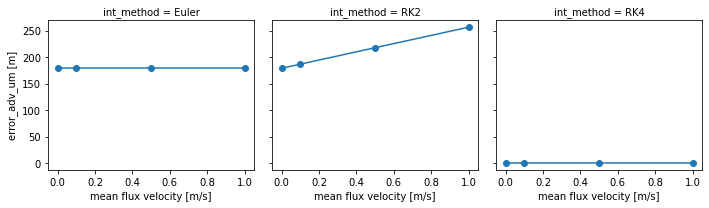

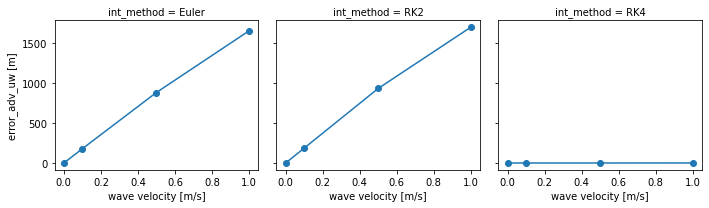

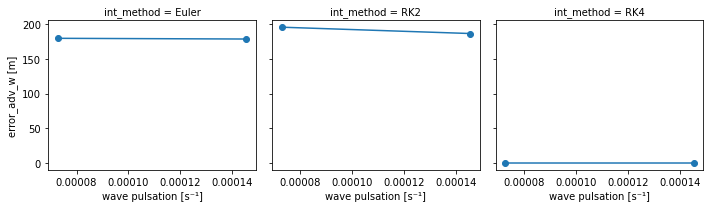

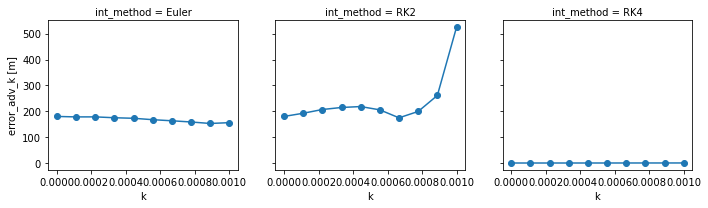

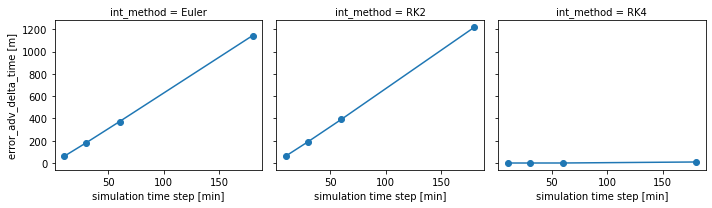

In [20]:
ds.error_adv_um.plot( col='int_method', marker='o')
ds.error_adv_uw.plot( col='int_method', marker='o')
ds.error_adv_w.plot( col='int_method', marker='o')
ds.error_adv_k.plot( col='int_method', marker='o')
ds.error_adv_delta_time.plot( x='delta_t_min', col='int_method', marker='o')

24